In [4]:
%matplotlib inline
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../")
import solvers as sv
import scipy as sp
import copy
from scipy.linalg import expm

In [5]:
def bernoulli_sampler(p,n=1):
    """" Sampling from bernoulli distribution """
    assert(p<=1)
    assert(p>=0)
    samples = [1 if x<p else 0 for x in np.random.random_sample(n)]
    if n==1:
        samples = samples[0]
    return samples  

def get_error(a,b):
    """Takes two list and return the ratio of similarity"""
    assert(len(a)==len(b))
    result = [None]*len(a)
    for i in range(len(a)):
        result[i] = (a[i] == b[i])   
    error = result.count(1)/float(len(a))
    return error

def sample_net(n_nodes,intercon=0.5,intracon=0.05,bal=0.25):
    net = nx.Graph()
    N1 = int(round(bal*n_nodes))
    labels = [0]*N1 +[1]* (n_nodes-N1)
    #adding ground turth nodes
    for i in range(N1):
        net.add_node(i,attr_dict={'class':'r'})
    for i in range(n_nodes-N1):
        net.add_node(i+N1,attr_dict={'class':'b'})
    #Adding edges
    for i in range(n_nodes):
        for j in range(i+1,n_nodes):
            if net.node[i]['attr_dict']['class']==net.node[j]['attr_dict']['class']:
                if bernoulli_sampler(intercon)==1:
                    net.add_edge(i,j)
            else:
                if bernoulli_sampler(intracon)==1:
                    net.add_edge(i,j)
    return net,labels

### Small network. Does communicability work better for clustering?

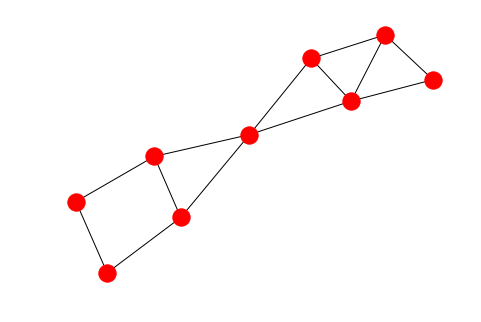

In [6]:
G = nx.Graph()
G.add_edges_from([(1,2),(1,3),(1,4),(2,4),(3,4),
                  (3,5),(4,5),(5,6),(5,7),(6,7),(6,8),(8,9),(7,9)])
A = nx.to_scipy_sparse_matrix(G,dtype=np.float64)
nx.draw(G)
plt.show()

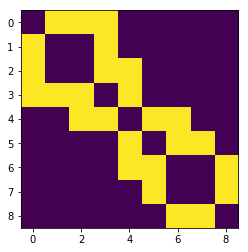

In [7]:
plt.imshow(A.todense())
plt.show()

In [13]:
eig,vec = np.linalg.eig(A.todense())
C = expm(A.todense()/(max(eig)))
C = sp.sparse.csr_matrix(C)
solver = sv.SemidefCluster(assign_labels='sampling')
solver.fit(C)

Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 10              
  Cones                  : 0               
  Scalar variables       : 1               
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 10              
  Cones               

In [14]:
solver.labels_

array([1, 1, 1, 1, 1, 1, 1, 0, 0])

### Testing CVXPY

$$\text{min}\quad x^{T}Lx$$

In [7]:
import cvxpy as cvx
#Create Laplacian
A = np.array(nx.to_numpy_matrix(G,dtype=np.float64))
D = np.diag(np.sum(A,axis=1))
L = D - A
print np.linalg.eig(L)[0] #positive definite?
#Setting cvxpy problem
x = cvx.Variable(L.shape[0])
obj = cvx.Minimize(cvx.quad_form(x,L))
constraint = [i*i ==1 for i in x]
prob = cvx.Problem(obj)
#solving and checking
print("Is the problem DCP:{}").format(prob.is_dcp()) #problem is DCP?
print constraint[5]
prob.solve()
print x.value

[-5.55111512e-17  3.95009885e-01  5.59091008e+00  4.73851335e+00
  3.92628295e+00  2.53405153e+00  1.81523221e+00  4.61803399e+00
  2.38196601e+00]
Is the problem DCP:True
affine_prod(var0[5, 0], var0[5, 0]) == 1
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


/Users/artun/anaconda2/lib/python2.7/site-packages/cvxpy/expressions/expression.py:291: UserWarning: Forming a nonconvex expression (affine)*(affine).
  warnings.warn("Forming a nonconvex expression (affine)*(affine).")


now with semidefinite programming

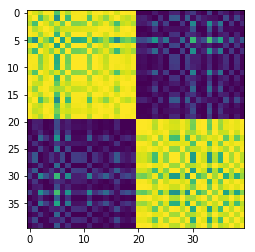

In [11]:
#Sampling net
G,labels = sample_net(40,intercon=0.5,intracon=0.2,bal=0.5)
A = np.array(nx.to_numpy_matrix(G,dtype=np.float64))
#Solving opt problem
X = cvx.Semidef(A.shape[0])
obj = cvx.Maximize(cvx.trace(A*X))
constr_eq = [X[i,i]==1 for i in range(A.shape[0])]
constr_ineq = [cvx.trace(np.ones(A.shape)*X) <= 1]
prob = cvx.Problem(obj,constr_eq+constr_ineq)
prob.solve(solver=cvx.MOSEK)
#x.T*x solution. Need to sample one x.
plt.imshow(X.value)

In [8]:
A = nx.to_scipy_sparse_matrix(net,dtype=np.float64)

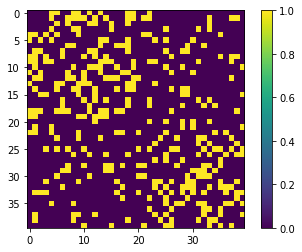

In [9]:
plt.imshow(A.todense())
plt.colorbar()
plt.show()

In [10]:
node_color=[d['attr_dict']['class'] for x,d in net.nodes(data=True)]
nx.draw_networkx(net,node_color=node_color)

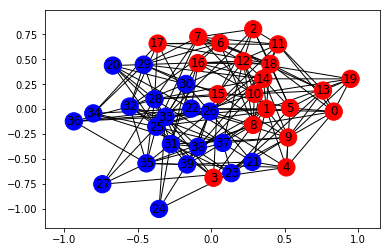

In [11]:
plt.show()

In [12]:
B = copy.copy(A)
B[B==0.]=-1.
solver = sv.SemidefCluster(assign_labels='sampling')
solver.fit(A)
solver1 = sv.SemidefCluster(assign_labels='sampling')
solver1.fit(B)

Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 41              
  Cones                  : 0               
  Scalar variables       : 1               
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)


/Users/artun/anaconda2/lib/python2.7/site-packages/scipy/sparse/compressed.py:214: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  ", try using != instead.", SparseEfficiencyWarning)
/Users/artun/anaconda2/lib/python2.7/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


  Constraints            : 41              
  Cones                  : 0               
  Scalar variables       : 1               
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer  - threads                : 4               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 41
Optimizer  - Cones                  : 0
Optimizer  - Scalar variables       : 1                 conic                  : 0               
Optimizer  - Semi-definite variables: 1                 scalarized             : 820             
Factor     - setup time             : 0.02              dense det. time        : 0.00            
Factor     - ML order time          : 0.00              GP order time          : 0.00            
Factor     - nonzeros before factor : 861               after factor           : 861             
Factor     - dense dim.             : 0                 flops                  : 2.70e+05        


In [13]:
print solver.labels_
print solver1.labels_

[1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0
 0 0 0]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


In [14]:
print get_error(solver.labels_,labels)
print get_error(solver1.labels_,labels)

0.225
0.925


In [35]:
print np.linalg.eig(solver.Z)[0][0:5]
print np.linalg.eig(solver1.Z)[0][0:5]
print np.linalg.eig(solver.Z)[1][0]
print np.linalg.eig(solver.Z)[1][1]

[22.49929287 10.9741244   4.17349357  2.04296362  0.31012553]
[22.4992755  10.97412859  4.17349713  2.04296059  0.31013817]
[-0.05563269 -0.23913175 -0.26736916  0.0467393   0.0056887   0.1991511
 -0.02323749 -0.3400429  -0.3344027  -0.07906406  0.32618891 -0.15595878
  0.24408231  0.06023715 -0.0635643  -0.02702381  0.00178527  0.06772019
  0.12900978 -0.0964382  -0.13754267  0.1185408  -0.11921306 -0.09145147
  0.0456257  -0.0285255   0.06468569 -0.05466584  0.09651414 -0.16813114
  0.03109324 -0.12171049  0.12068289 -0.08733638  0.15920086 -0.28748482
 -0.11043866  0.04894531  0.26492132  0.17013353]
[ 0.18402426  0.07124461  0.18774051  0.12763013 -0.07992015  0.08579161
 -0.35251436  0.13206567 -0.33217619 -0.22704367 -0.24209616 -0.02771801
  0.02280435  0.18024394 -0.09320659 -0.18465117 -0.33240591 -0.23595607
 -0.2408004  -0.20851717 -0.15248486  0.03379463  0.11546952  0.1286018
 -0.13727744  0.02633443 -0.12584115 -0.21235829 -0.01631649 -0.1229652
  0.13001485 -0.02511208  

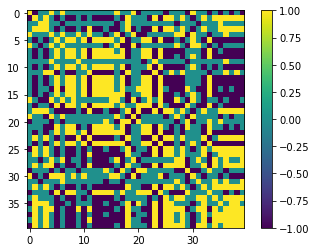

In [36]:
plt.imshow(np.round(np.array(solver.Z)))
plt.colorbar()
plt.show()

In [37]:
Zt = solver.Z

In [38]:
type(Zt)

cvxopt.base.matrix

In [39]:
solverp = sv.SemidefCluster(assign_labels='sampling')
solverp.fit(A,solver.Z)

114.0
without
134.0
without
138.0
without
150.0
without
158.0
without
166.0
without
170.0
without


In [40]:
com_cent = nx.communicability(net)

In [41]:
C = sp.sparse.csr_matrix((n_nodes,n_nodes), dtype=np.float64 )
for n,dic in com_cent.items():
    for n2,com in dic.items():
        C[n,n2] = com
eig,vec = np.linalg.eig(A.todense())
C = sp.linalg.expm(A.todense()/max(eig))-np.eye(n_nodes)
C = sp.sparse.csr_matrix(C)

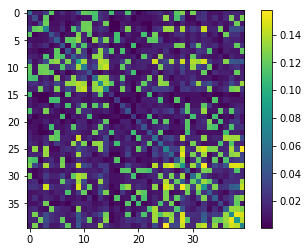

In [42]:
plt.imshow(C.todense())
plt.colorbar()
plt.show()

In [43]:
solver1 = sv.SemidefCluster(assign_labels='sampling')
solver1.fit(C)

Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 41              
  Cones                  : 0               
  Scalar variables       : 1               
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 41              
  Cones               

In [44]:
get_error(solver1.labels_,labels)

0.425

In [45]:
solver1.labels_

array([0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [62]:
S = np.random.multivariate_normal(np.array([0,0]),np.array([[1,1],[1,1]]),50)

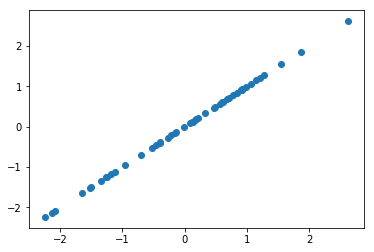

In [63]:
plt.scatter(S[:,0],S[:,1])
plt.show()

In [64]:
pts = [x for x in S if x[0]<0 and x[1]<0]
np.linalg.eig(np.array([[1,1],[1,1]]))

(array([2., 0.]), array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]))

In [148]:
alpha = lambda n,p: p*n/np.log10(n)
beta = lambda n,q: q*n/np.log10(n)
N = np.arange(5,800)
n = 200
p = 0.15
q = 0.05
y = (alpha(N,p)+beta(N,q))/2-np.sqrt(alpha(N,p)*beta(N,q))
y2 = (alpha(N,0.5)+beta(N,q))/2-np.sqrt(alpha(N,0.5)*beta(N,q))
level = np.ones(len(N))

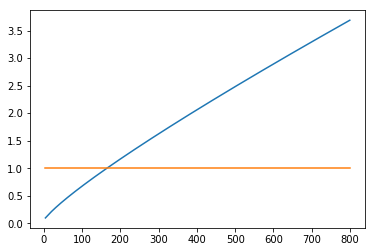

In [149]:
import matplotlib.pyplot as plt
plt.plot(N,y)
#plt.plot(N,y2)
plt.plot(N,level)

plt.show()

In [151]:
N[y>1][0:5]

array([166, 167, 168, 169, 170])

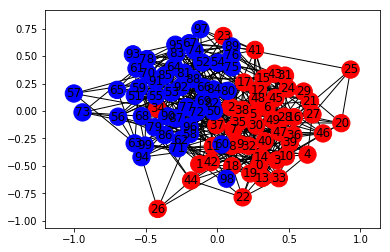

In [162]:
n_nodes = 100
net,labels = sample_net(n_nodes,p,q,0.5)
node_color=[d['attr_dict']['class'] for x,d in net.nodes(data=True)]
nx.draw_networkx(net,node_color=node_color)
plt.show()

In [163]:
A = nx.to_scipy_sparse_matrix(net,dtype=np.float64)
solver = sv.SemidefCluster(assign_labels='sampling')
solver.fit(A)
print solver.labels_
print get_error(solver.labels_,labels)

Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 101             
  Cones                  : 0               
  Scalar variables       : 1               
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 101             
  Cones               